<a href="https://colab.research.google.com/github/lazybuttrying/TensorFlow-Certificate/blob/main/C4/W2/ungraded_labs/C4_W2_Lab_3_deep_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [2]:
#!pip install tensorflow==2.5.0

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.6.0


In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

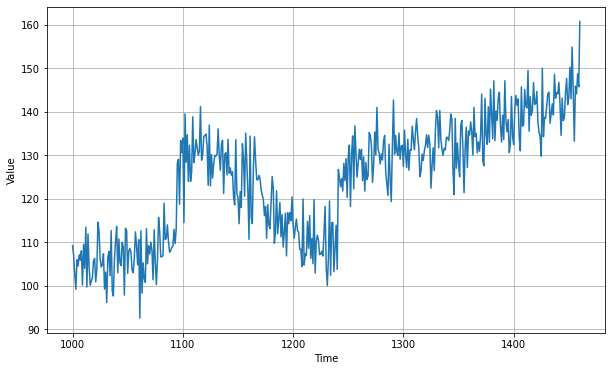

In [5]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)


In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [7]:
# x_train 데이터를 전달하여 생성할 dataset을 가져옴
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
                              # input_shape = winow_size
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)


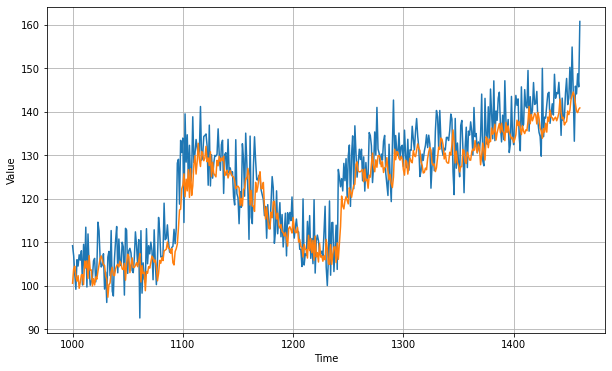

In [8]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [9]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.0650434

In [10]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

# 각 epoch의 마지막마다 호출되어
# epoch 횟수를 체크해가며 leaning_rate를 수정
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0) # 여기서 callback 지정

(1e-08, 0.001, 0.0, 300.0)

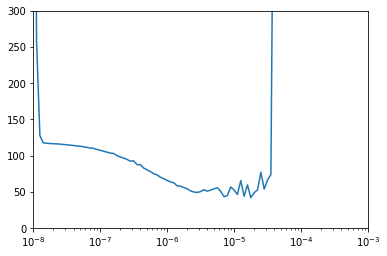

In [11]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])
# x축 = learning_rate
# y축 = 해당 epoch에서의 loss

In [39]:
window_size = 20 # 30으로 하니깐 노이즈가 심해서 여러 가지 시도 중
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])
# 0.000008 이전보다 약 800배 learning rate를 올리면
optimizer = tf.keras.optimizers.SGD(learning_rate=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

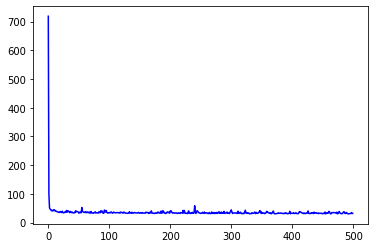

In [40]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()
# 거의 10 epoch 때 peak를 찍어서
# 그 부분을 잘라내고 다시 그래프를 그린 게 두번째 아래 그림

[45.14448928833008, 40.86508560180664, 41.209754943847656, 39.08732223510742, 39.24751281738281, 37.3767204284668, 37.260372161865234, 36.302608489990234, 35.15940856933594, 38.44949722290039, 38.50768280029297, 35.72331237792969, 35.44163513183594, 39.7816276550293, 34.68703842163086, 34.3150749206543, 34.614681243896484, 36.125064849853516, 39.037208557128906, 36.4829216003418, 42.26323318481445, 36.497642517089844, 40.464168548583984, 40.80815505981445, 38.03178787231445, 34.59868621826172, 39.2260627746582, 36.53037643432617, 35.13980484008789, 37.04678726196289, 34.176631927490234, 34.324405670166016, 33.83638000488281, 36.003509521484375, 34.97553253173828, 41.60927963256836, 37.90758514404297, 38.651065826416016, 38.509613037109375, 37.07151412963867, 33.20610046386719, 33.91880416870117, 37.17352294921875, 34.73833084106445, 34.484466552734375, 52.77782440185547, 39.93067169189453, 37.07899856567383, 36.91999816894531, 35.52510452270508, 35.66984558105469, 38.319664001464844, 3

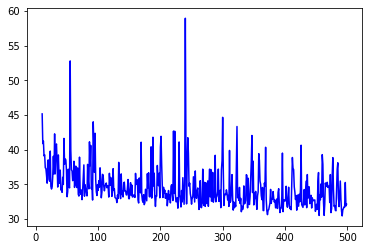

In [41]:
# window == 30
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

# 강의 영상에선 윗 그래프도, 아래 그래프도 매끄러운 곡선 하나^^;;

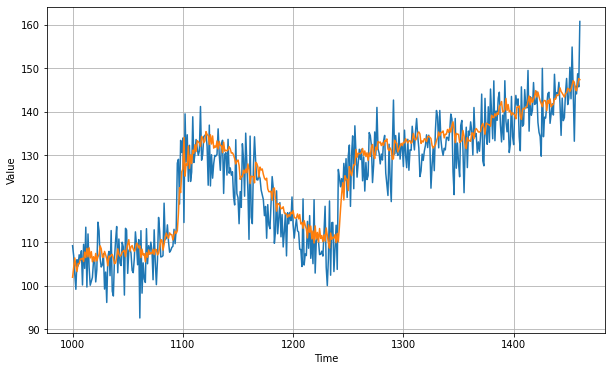

In [42]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [43]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy() 
#window == 20 이면 오차 감소함 5->4
# window == 80 이면 오차 비슷


4.7164316

[4010.219970703125, 3978.753662109375, 3947.46630859375, 3916.5, 3885.807861328125, 3855.521484375, 3825.35302734375, 3795.648193359375, 3766.243896484375, 3736.928955078125, 3707.990234375, 3679.399169921875, 3651.01708984375, 3622.9404296875, 3595.0673828125, 3567.336669921875, 3540.1962890625, 3513.079345703125, 3486.30517578125, 3459.63427734375, 3433.490234375, 3407.40478515625, 3381.613037109375, 3356.057861328125, 3330.866943359375, 3305.80078125, 3280.980224609375, 3256.3603515625, 3232.09033203125, 3207.97607421875, 3184.158203125, 3160.433837890625, 3137.097900390625, 3113.91455078125, 3090.855224609375, 3068.1767578125, 3045.639892578125, 3023.31005859375, 3001.248779296875, 2979.297119140625, 2957.67138671875, 2936.171875, 2914.878173828125, 2893.9140625, 2872.994140625, 2852.279296875, 2831.866455078125, 2811.67138671875, 2791.4423828125, 2771.67529296875, 2752.013427734375, 2732.458984375, 2713.1201171875, 2693.963134765625, 2675.11962890625, 2656.264404296875, 2637.74902

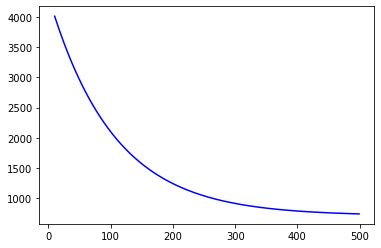

In [33]:
# Plot all but the first 10
# window == 45
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

69.60974

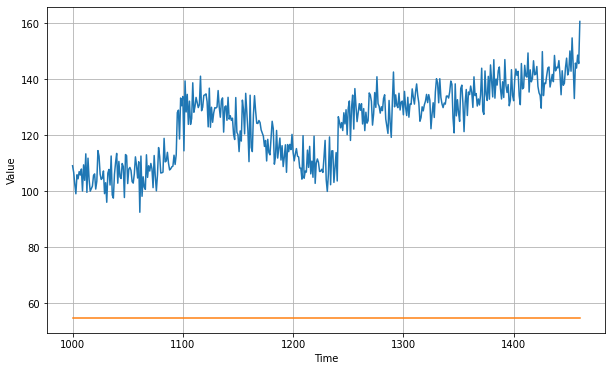

In [34]:
# window == 45

forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

tf.keras.metrics.mean_absolute_error(x_valid, results).numpy() 
# 노이즈를 없앤다고 노력하는 게 중요한 게 아니구나ㅠㅠ